## IMPORTS

In [29]:
import yfinance as yf
import json
from datetime import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import sys
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import warnings
import os
import sys

warnings.filterwarnings('ignore')

# BEST FOR NOW

In [30]:
# SINGLE LSTM(124) BIDIRECTIONAL LAYER WITH 4 FEATURES AND 90% OF DATA IS TRAINING, 7.5% VALIDATION, 2.5% TEST\
# 30 weeks
# 100 EPOCHS WITH 32 BATCHES
# RSI OF PERIOD 7 AND AROON OF 14
start_date = pd.to_datetime('19900101').tz_localize('America/New_York')
sequence_length = 2
epochs = 100
batches = 32
features = ['Close', 'RSI', 'AroonUp', 'AroonDown']

rsi_period=7
aroon_period=14

training_scaler = 0.9
validation_scaler = 0.075
test_scaler = 0.025

lstm_complexity = 124
out_pred = 1

# SINGLE LSTM(124) BIDIRECTIONAL LAYER WITH 4 FEATURES AND 85% OF DATA IS TRAINING, 12,5%% VALIDATION, 2.5% TEST
# 30 weeks
# 100 EPOCHS WITH 32 BATCHES
# RSI OF PERIOD 7 AND AROON OF 14
# THIS ONE LOOKS MORE IMPRECISE BUT IS RESULTING IN MORE GAINS
start_date = pd.to_datetime('19900101').tz_localize('America/New_York')
sequence_length = 2
epochs = 100
batches = 32
features = ['Close', 'RSI', 'AroonUp', 'AroonDown']

rsi_period=7
aroon_period=14

training_scaler = 0.85
validation_scaler = 0.125
test_scaler = 0.025

lstm_complexity = 124
out_pred = 1

# SINGLE LSTM(124) BIDIRECTIONAL LAYER WITH 4 FEATURES AND 80% OF DATA IS TRAINING, 17.5% VALIDATION, 2.5% TEST
# 40 weeks
# 100 EPOCHS WITH 32 BATCHES
# RSI OF PERIOD 7 AND MACD OF 12-26-9
# THIS ONE LOOKS INCREDIBLY PRECISE. BEST GAINS YET (AMAZING??)
start_date = pd.to_datetime('19900101').tz_localize('America/New_York')
sequence_length = 2
epochs = 100
batches = 32
features = ['Close', 'RSI', 'MACD_Hist', 'Signal']

# RSI PARAMS
rsi_period=7

#MACD PARAMS
fast_period = 12
slow_period = 26
signal_period = 9

training_scaler = 0.8
validation_scaler = 0.175
test_scaler = 0.025

lstm_complexity = 124
out_pred = 1

# SINGLE LSTM(124) BIDIRECTIONAL LAYER WITH 4 FEATURES AND 80% OF DATA IS TRAINING, 17.5% VALIDATION, 2.5% TEST
# 40 weeks
# 100 EPOCHS WITH 32 BATCHES
# RSI OF PERIOD 7 AND MACD OF 12-26-9
# Dense layer 7 predictions
start_date = pd.to_datetime('19900101').tz_localize('America/New_York')
sequence_length = 2
epochs = 100
batches = 32
features = ['Close', 'RSI', 'MACD_Hist', 'Signal']

# RSI PARAMS
rsi_period=7

#MACD PARAMS
fast_period = 12
slow_period = 26
signal_period = 9

training_scaler = 0.8
validation_scaler = 0.175
test_scaler = 0.025

lstm_complexity = 124
out_pred = 1

## VARIABLES

In [31]:
start_date = pd.to_datetime('19900101').tz_localize('America/New_York')
sequence_length = 2
epochs = 100
batches = 32
features = ['Close', 'RSI', 'MACD_Hist', 'Signal']

# RSI PARAMS
rsi_period=7

#AROON PARAMS
aroon_period = 14

#MACD PARAMS
fast_period = 12
slow_period = 26
signal_period = 9

training_scaler = 0.8
validation_scaler = 0.175
test_scaler = 0.025

lstm_complexity = 124

## FUNCTIONS

In [32]:
import pandas as pd

def calculate_rsi(data, period=rsi_period):
    # Calculate the difference in prices
    delta = data['Close'].diff()
    
    # Make the positive gains (up) and negative gains (down) Series
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    # Calculate the average gain and loss
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()
    
    # Calculate the Relative Strength (RS)
    rs = avg_gain / avg_loss
    
    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

def calculate_aroon(data, period=aroon_period):
    # Initialize the Aroon Up and Aroon Down columns with NaN
    data['AroonUp'] = np.nan
    data['AroonDown'] = np.nan
    
    for i in range(period, len(data)):
        highest_high = data['Close'].iloc[i-period:i].max()
        lowest_low = data['Close'].iloc[i-period:i].min()
        
        # Calculate the number of periods since the highest high and lowest low
        periods_since_highest_high = period - data['Close'].iloc[i-period:i].iloc[::-1].tolist().index(highest_high)
        periods_since_lowest_low = period - data['Close'].iloc[i-period:i].iloc[::-1].tolist().index(lowest_low)
        
        data.at[data.index[i], 'AroonUp'] = (periods_since_highest_high / period) * 100
        data.at[data.index[i], 'AroonDown'] = (periods_since_lowest_low / period) * 100
        
    return data

def add_macd(df, fast_period=fast_period, slow_period=slow_period, signal_period=signal_period):
    """
    Adds MACD, Signal line, and MACD Histogram to the DataFrame.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the 'Close' price column.
    fast_period (int): Period for the fast EMA (default is 12).
    slow_period (int): Period for the slow EMA (default is 26).
    signal_period (int): Period for the signal line EMA (default is 9).
    
    Returns:
    pd.DataFrame: DataFrame with added MACD, Signal line, and MACD Histogram columns.
    """
    # Calculate the fast and slow EMAs
    df['EMA_fast'] = df['Close'].ewm(span=fast_period, adjust=False).mean()
    df['EMA_slow'] = df['Close'].ewm(span=slow_period, adjust=False).mean()
    
    # Calculate the MACD
    df['MACD'] = df['EMA_fast'] - df['EMA_slow']
    
    # Calculate the Signal line
    df['Signal'] = df['MACD'].ewm(span=signal_period, adjust=False).mean()
    
    # Calculate the MACD Histogram
    df['MACD_Hist'] = df['MACD'] - df['Signal']
    
    # Drop the intermediate EMA columns
    df.drop(columns=['EMA_fast', 'EMA_slow'], inplace=True)
    
    return df


## OBTAINING DATA
1) Tickers
2) Data treatment
3) Sequence creation
4) Data splitting

In [33]:
ticker_list=[]

ticker_list.append(yf.Ticker("GOOG"))
# ticker_list.append(yf.Ticker("GOOG"))

In [34]:
df_scaled_list = []

for ticker in ticker_list:
    # data = ticker.history(period='max')
    
    # data = data[data.index>=start_date]
    data = pd.read_csv('MSFT_15.csv', sep=';', index_col=0)
    
    data['RSI'] = calculate_rsi(data)
    data = calculate_aroon(data)
    data = add_macd(data)
    
    data.dropna(inplace=True)

    # Obtain closing price and volume
    # close_data = data['Close'][data.index>=start_date]
    # close_data.fillna(method='ffill', inplace=True)

    # open_data = data['Close'][data.index>=start_date]
    # open_data.fillna(method='ffill', inplace=True)

    # volume_data = data['Volume'][data.index>=start_date]
    # volume_data.fillna(method='ffill', inplace=True)    
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))

    # close_scaled_data = scaler.fit_transform(close_data.values.reshape(-1,1))
    # open_scaled_data = scaler.fit_transform(open_data.values.reshape(-1,1))
    # volume_scaled_data = scaler.fit_transform(volume_data.values.reshape(-1,1))
    
    
    df_scaled = scaler.fit_transform(data[features])

In [35]:
# Create sequences
def create_sequence(sequence_length, data):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X, y = create_sequence(sequence_length, df_scaled)

In [36]:
assert training_scaler + test_scaler + validation_scaler == 1.0

# Calculate split indices
train_split = int(training_scaler * len(X))
test_split = int(test_scaler * len(X))
val_split = len(X) - train_split - test_split

print('Data Length: ', len(X))
print('Train length: ', train_split)
print('Validation length: ', val_split)
print('Test length: ', test_split)

# Split the data
X_train = X[:train_split]
X_val = X[train_split:train_split+val_split]
X_test = X[train_split+val_split:]

y_train = y[:train_split]
y_val = y[train_split:train_split+val_split]
y_test = y[train_split+val_split:]

# Display the shapes of the datasets
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of X_val: {X_val.shape}')
print(f'Shape of y_val: {y_val.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

Data Length:  76634
Train length:  61307
Validation length:  13412
Test length:  1915
Shape of X_train: (61307, 2, 4)
Shape of y_train: (61307,)
Shape of X_val: (13412, 2, 4)
Shape of y_val: (13412,)
Shape of X_test: (1915, 2, 4)
Shape of y_test: (1915,)


## GENERATE MODEL

In [37]:
# Build the LSTM model #
########################
model = Sequential()
model.add(Bidirectional(LSTM(units=lstm_complexity, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2]))))
# model.add(Bidirectional(LSTM(units=lstm_complexity, return_sequences=True)))
# model.add(Bidirectional(LSTM(units=lstm_complexity)))
model.add(Dropout(0.2))
# model.add(LSTM(units=50, return_sequences=False))
# model.add(Dropout(0.2))
model.add(Dense(units=out_pred))

print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [38]:
cp_path = 'model_cp.keras'
if os.path.exists(cp_path):
    os.remove(cp_path)
    
cp = ModelCheckpoint(cp_path, save_best_only=True)
model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [39]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batches, callbacks=[cp,early_stopping])

Epoch 1/100
1916/1916 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0115 - val_loss: 1.4383e-04
Epoch 2/100
1916/1916 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 5.2764e-04 - val_loss: 1.1603e-05
Epoch 3/100
1916/1916 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 4.0098e-04 - val_loss: 1.4634e-05
Epoch 4/100
1916/1916 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2.7528e-04 - val_loss: 8.3178e-06
Epoch 5/100
1916/1916 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.7799e-04 - val_loss: 7.9901e-05
Epoch 6/100
1916/1916 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.3147e-04 - val_loss: 5.2619e-06
Epoch 7/100
1916/1916 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 9.8096e-05 - val_loss: 1.0819e-05
Epoch 8/100
1916/1916 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 7.7644e-05 - val_loss: 4.9240e-06
Epoch 9/100
1916/1916 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 7.6370e-05 - val_loss: 6.3304e-06
Epoch 10/100
1916/1916 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 7.3512e-05 - val_loss: 3.8698e-05
Epoch 11/100
1916/1916 ━━━━━━━━━━

In [40]:
# Load the best model
model.load_weights(cp_path)
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Make predictions on the test set
y_pred = model.predict(X_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 3.8441e-06
Test Loss: 4.596177859639283e-06
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


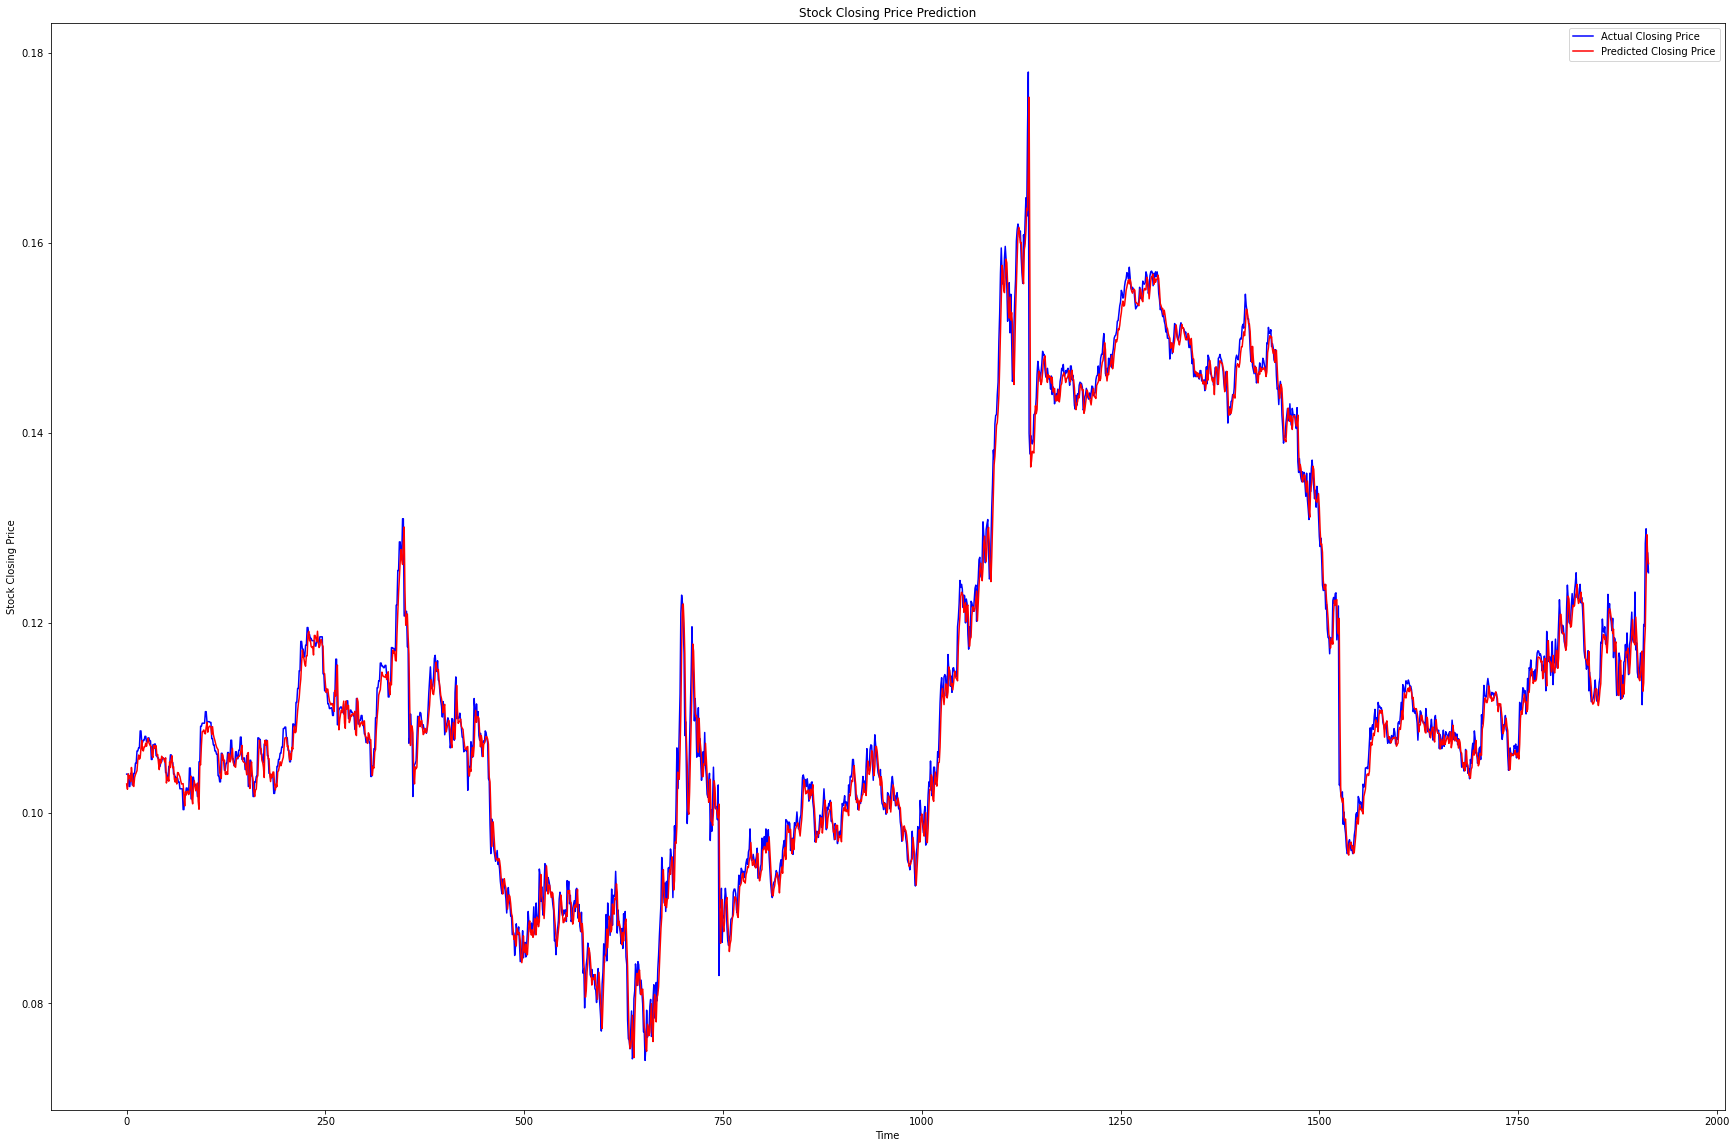

In [41]:
# Plot the results
plt.figure(figsize=(30, 20))
plt.plot(y_test, color='blue', label='Actual Closing Price')
plt.plot(y_pred, color='red', label='Predicted Closing Price')
plt.title('Stock Closing Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Closing Price')
plt.legend()
plt.show()

## SIGNALING

<class 'numpy.ndarray'>


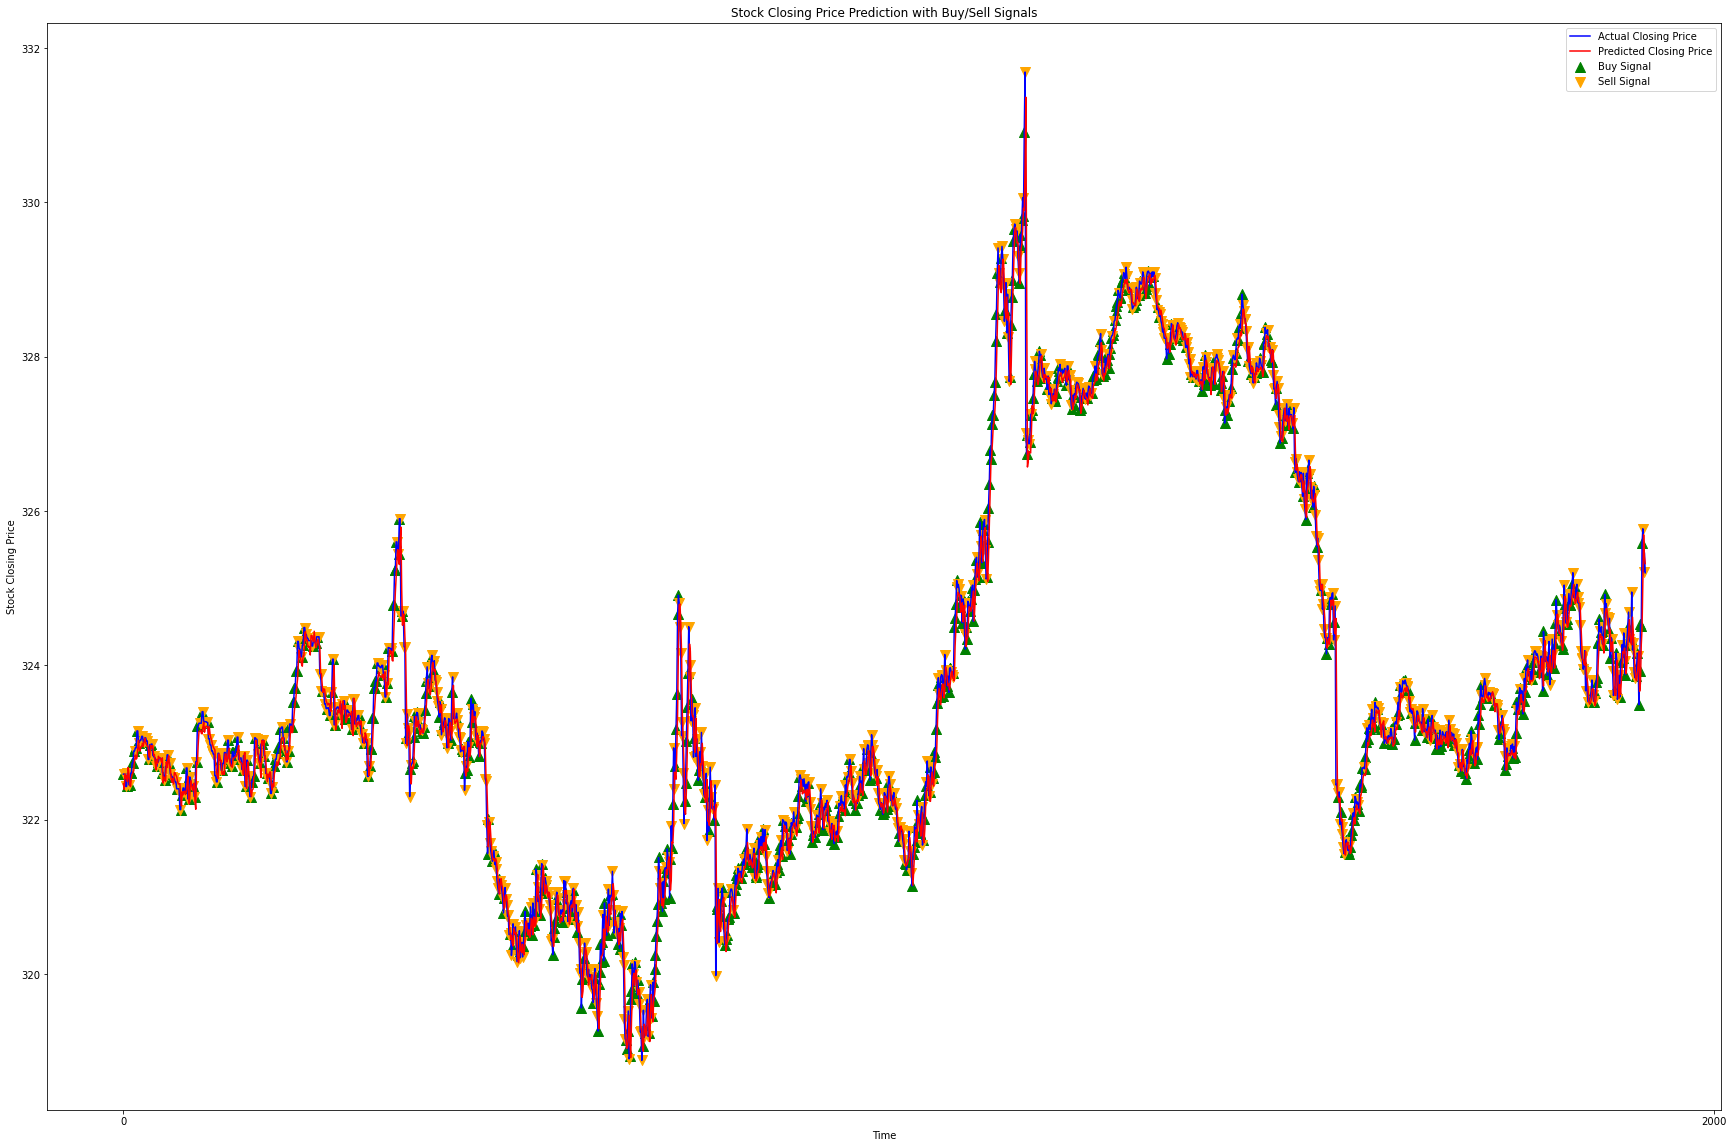

Total Profit: 255.59
Number of Trades: 428
Average Profit per Trade: 0.60


In [42]:
test=[1,2,3]
print(type(y_test))

def duplicate_features(data, n_features=len(features)):
    return np.tile(data.reshape(-1, 1), n_features)

# Duplicate y_test and y_pred to have 4 identical columns
y_test_duplicated = duplicate_features(y_test)
y_pred_duplicated = duplicate_features(y_pred)

# Perform inverse transform
y_test_original_duplicated = scaler.inverse_transform(y_test_duplicated)
y_pred_original_duplicated = scaler.inverse_transform(y_pred_duplicated)

# Extract the first column
y_test_original = y_test_original_duplicated[:, 0]
y_pred_original = y_pred_original_duplicated[:, 0]


# Create DataFrame
# y_pred = y_pred.flatten()
df = pd.DataFrame({
    'actual': y_test_original,
    'predicted': y_pred_original
})

# Generate trading signals
df['buy_signal'] = df['predicted'].diff().shift(-2) > 0
df['sell_signal'] = df['predicted'].diff().shift(-2) < 0

# # Initialize variables for tracking trades
# position = 0  # 1 for holding, 0 for not holding
# buy_price = 0
# total_profit = 0
# trades = []


# # Simulate trades
# for i in range(len(df)):
#     if df['buy_signal'][i] and position == 0:
#         # Buy
#         position = 1
#         buy_price = df['actual'][i]
#     elif df['sell_signal'][i] and position == 1:
#         # Sell
#         position = 0
#         sell_price = df['actual'][i]
#         profit = sell_price - buy_price
#         total_profit += profit
#         trades.append({'buy_price': buy_price, 'sell_price': sell_price, 'profit': profit})

# Initialize variables for tracking trades
position = 0  # 1 for holding, 0 for not holding
buy_price = 0
total_profit = 0
trades = []

buys = []

# Simulate trades
for i in range(len(df)):
    if df['buy_signal'][i]:
        # Buy
        position = 1
        buy_price = df['actual'][i]
        buys.append(buy_price)
    elif df['sell_signal'][i] and position == 1:
        # Sell
        position = 0
        sell_price = df['actual'][i]
        profit = sum(sell_price - x for x in buys)
        total_profit += profit
        trades.append({'buy_price': buy_price, 'sell_price': sell_price, 'profit': profit})
        buys = []

# Identify buy and sell indices
buy_indices = df.index[df['buy_signal']].tolist()
sell_indices = df.index[df['sell_signal']].tolist()

# Convert trades to DataFrame for analysis
trades_df = pd.DataFrame(trades)

# Plot the results
plt.figure(figsize=(30, 20))
plt.plot(df['actual'], color='blue', label='Actual Closing Price')
plt.plot(df['predicted'], color='red', label='Predicted Closing Price')

# Plot buy and sell signals
plt.scatter(buy_indices, df['actual'][buy_indices], color='green', marker='^', s=100, label='Buy Signal')
plt.scatter(sell_indices, df['actual'][sell_indices], color='orange', marker='v', s=100, label='Sell Signal')

plt.title('Stock Closing Price Prediction with Buy/Sell Signals')
plt.xlabel('Time')
plt.ylabel('Stock Closing Price')
plt.legend()

plt.locator_params(axis='x', nbins=2)

plt.show()

# Print performance metrics
print(f"Total Profit: {total_profit:.2f}")
print(f"Number of Trades: {len(trades_df)}")
print(f"Average Profit per Trade: {trades_df['profit'].mean():.2f}")
